In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm

from keras import backend as K
from keras import optimizers

from keras.layers import Input, Dense, Lambda, Layer, Add, Multiply
from keras.models import Model, Sequential
from keras.datasets import mnist
from keras.losses import mean_squared_error
from keras import layers as KL

import uproot
import numpy
from scipy import stats
import matplotlib.pyplot
import pandas as pd
from pathlib import Path

from keras.layers import Input, Dense, Lambda, Layer, LeakyReLU, ReLU
from keras.models import Model
from keras import backend as K
from keras import metrics
from keras import optimizers
from keras.callbacks import EarlyStopping, ReduceLROnPlateau, BaseLogger, \
TerminateOnNaN, Callback, ModelCheckpoint, LambdaCallback

from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler
from sklearn.model_selection import train_test_split

from keras.constraints import max_norm
# from sklearn.externals.joblib import dump, load

from numpy.random import seed
import time
import re

import json
import pickle
import os
import shutil

import random as rn

np.random.seed(42)
# The below is necessary for starting core Python generated random numbers
# in a well-defined state.
rn.seed(12345)

# import ray
# from ray.tune.integration.keras import TuneReporterCallback
# from ray import tune
# from ray.tune.schedulers import AsyncHyperBandScheduler, ASHAScheduler, PopulationBasedTraining
import random
import csv

from scipy import stats

from config import *
from vae_utility import *

Using TensorFlow backend.
/home/roberto/anaconda3/envs/exotica_ray/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:523: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/roberto/anaconda3/envs/exotica_ray/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:524: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/roberto/anaconda3/envs/exotica_ray/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:525: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/h

In [2]:
original_dim = 3

latent_dim = 3
intermediate_dim = 50
kernel_max_norm = 500.
act_fun = 'relu'
weight_KL_loss = 0.6

Nf_lognorm = 3
Nf_PDgauss = 0

In [3]:
def KL_loss_forVAE(mu, sigma, mu_prior, sigma_prior):
    kl_loss = K.tf.multiply(K.square(sigma), K.square(sigma_prior))
    kl_loss += K.square(K.tf.divide(mu_prior - mu, sigma_prior))
    kl_loss += K.log(K.tf.divide(sigma_prior, sigma)) -1
    return 0.5 * K.sum(kl_loss, axis=-1)

#######################################################################
def RecoProb_forVAE(x, par1, par2, par3, w):

    N = 0
    nll_loss = 0

    if Nf_lognorm != 0:

        for i in range(Nf_lognorm):

            #Log-Normal distributed variables
            mu = par1[:,i:i+1]
            sigma = par2[:,i:i+1]
            fraction = par3[:,i:i+1]
            x_clipped = K.clip(x[:,i:i+1], clip_x_to0, 1e8)
            single_NLL = K.tf.where(K.less(x[:,i:i+1], clip_x_to0),
                                    -K.log(fraction),
                                        -K.log(1-fraction)
                                        + K.log(sigma)
                                        + K.log(x_clipped)
                                        + 0.5*K.square(K.tf.divide(K.log(x_clipped) - mu, sigma)))
            nll_loss += K.sum(w[i]*single_NLL, axis=-1)

        N += Nf_lognorm

    if Nf_PDgauss != 0:

        for i in range(N, N+Nf_PDgauss):

            mu = par1[:,i:i+1]
            sigma = par2[:,i:i+1]
            norm_xp = K.tf.divide(x[:,i:i+1] + 0.5 - mu, sigma)
            norm_xm = K.tf.divide(x[:,i:i+1] - 0.5 - mu, sigma)
            sqrt2 = 1.4142135624
            single_LL = 0.5*(K.tf.erf(norm_xp/sqrt2) - K.tf.erf(norm_xm/sqrt2))

            norm_0 = K.tf.divide(-0.5 - mu, sigma)
            aNorm = 1 + 0.5*(1 + K.tf.erf(norm_0/sqrt2))
            single_NLL = -K.log(K.clip(single_LL, 1e-10, 1e40)) -K.log(aNorm)

            nll_loss += K.sum(w[i]*single_NLL, axis=-1)

    return nll_loss


def IndividualRecoProb_forVAE_lognorm_1(x, par1, par2, par3, w):
    N = 0
    nll_loss = 0

    mu = par1[:,:1]
    sigma = par2[:,:1]
    fraction = par3[:,:1]
    x_clipped = K.clip(x[:,:1], clip_x_to0, 1e8)
    single_NLL = K.tf.where(K.less(x[:,:1], clip_x_to0),
                            -K.log(fraction),
                                -K.log(1-fraction)
                                + K.log(sigma)
                                + K.log(x_clipped)
                                + 0.5*K.square(K.tf.divide(K.log(x_clipped) - mu, sigma)))
    nll_loss += K.sum(w*single_NLL, axis=-1)

    return nll_loss

def IndividualRecoProb_forVAE_lognorm_2(x, par1, par2, par3, w):
    N = 0
    nll_loss = 0

    mu = par1[:,1:2]
    sigma = par2[:,1:2]
    fraction = par3[:,1:2]
    x_clipped = K.clip(x[:,1:2], clip_x_to0, 1e8)
    single_NLL = K.tf.where(K.less(x[:,1:2], clip_x_to0),
                            -K.log(fraction),
                                -K.log(1-fraction)
                                + K.log(sigma)
                                + K.log(x_clipped)
                                + 0.5*K.square(K.tf.divide(K.log(x_clipped) - mu, sigma)))
    nll_loss += K.sum(w*single_NLL, axis=-1)

    return nll_loss

def IndividualRecoProb_forVAE_lognorm_3(x, par1, par2, par3, w):
    N = 0
    nll_loss = 0

    mu = par1[:,2:3]
    sigma = par2[:,2:3]
    fraction = par3[:,2:3]
    x_clipped = K.clip(x[:,2:3], clip_x_to0, 1e8)
    single_NLL = K.tf.where(K.less(x[:,2:3], clip_x_to0),
                            -K.log(fraction),
                                -K.log(1-fraction)
                                + K.log(sigma)
                                + K.log(x_clipped)
                                + 0.5*K.square(K.tf.divide(K.log(x_clipped) - mu, sigma)))
    nll_loss += K.sum(w*single_NLL, axis=-1)

    return nll_loss

def IndividualRecoProb_forVAE_lognorm_4(x, par1, par2, par3, w):
    N = 0
    nll_loss = 0

    mu = par1[:,3:4]
    sigma = par2[:,3:4]
    fraction = par3[:,3:4]
    x_clipped = K.clip(x[:,3:4], clip_x_to0, 1e8)
    single_NLL = K.tf.where(K.less(x[:,3:4], clip_x_to0),
                            -K.log(fraction),
                                -K.log(1-fraction)
                                + K.log(sigma)
                                + K.log(x_clipped)
                                + 0.5*K.square(K.tf.divide(K.log(x_clipped) - mu, sigma)))
    nll_loss += K.sum(w*single_NLL, axis=-1)

    return nll_loss

def IndividualRecoProb_forVAE_lognorm_5(x, par1, par2, par3, w):
    N = 0
    nll_loss = 0

    mu = par1[:,4:5]
    sigma = par2[:,4:5]
    fraction = par3[:,4:5]
    x_clipped = K.clip(x[:,4:5], clip_x_to0, 1e8)
    single_NLL = K.tf.where(K.less(x[:,4:5], clip_x_to0),
                            -K.log(fraction),
                                -K.log(1-fraction)
                                + K.log(sigma)
                                + K.log(x_clipped)
                                + 0.5*K.square(K.tf.divide(K.log(x_clipped) - mu, sigma)))
    nll_loss += K.sum(w*single_NLL, axis=-1)

    return nll_loss


def individualRecoProb_forVAE_discrete_6(x, par1, par2, w):
    nll_loss = 0

    mu = par1[:,5:6]
    sigma = par2[:,5:6]
    norm_xp = K.tf.divide(x[:,5:6] + 0.5 - mu, sigma)
    norm_xm = K.tf.divide(x[:,5:6] - 0.5 - mu, sigma)
    sqrt2 = 1.4142135624
    single_LL = 0.5*(K.tf.erf(norm_xp/sqrt2) - K.tf.erf(norm_xm/sqrt2))

    norm_0 = K.tf.divide(-0.5 - mu, sigma)
    aNorm = 1 + 0.5*(1 + K.tf.erf(norm_0/sqrt2))
    single_NLL = -K.log(K.clip(single_LL, 1e-10, 1e40)) -K.log(aNorm)

    nll_loss += K.sum(w*single_NLL, axis=-1)

    return nll_loss


def individualRecoProb_forVAE_discrete_7(x, par1, par2, w):
    nll_loss = 0

    mu = par1[:,6:7]
    sigma = par2[:,6:7]
    norm_xp = K.tf.divide(x[:,6:7] + 0.5 - mu, sigma)
    norm_xm = K.tf.divide(x[:,6:7] - 0.5 - mu, sigma)
    sqrt2 = 1.4142135624
    single_LL = 0.5*(K.tf.erf(norm_xp/sqrt2) - K.tf.erf(norm_xm/sqrt2))

    norm_0 = K.tf.divide(-0.5 - mu, sigma)
    aNorm = 1 + 0.5*(1 + K.tf.erf(norm_0/sqrt2))
    single_NLL = -K.log(K.clip(single_LL, 1e-10, 1e40)) -K.log(aNorm)

    nll_loss += K.sum(w*single_NLL, axis=-1)

    return nll_loss



In [4]:
class CustomKLLossLayer(Layer):
    def __init__(self, **kwargs):
        self.is_placeholder = True
        super(CustomKLLossLayer, self).__init__(**kwargs)

    def call(self, inputs):
        mu, sigma, mu_prior, sigma_prior = inputs
        return KL_loss_forVAE(mu, sigma, mu_prior, sigma_prior)


class CustomRecoProbLayer(Layer):
    def __init__(self, **kwargs):
        self.is_placeholder = True
        super(CustomRecoProbLayer, self).__init__(**kwargs)

    def call(self, inputs):
        x, par1, par2, par3 = inputs
        return RecoProb_forVAE(x, par1, par2, par3, w = w)

#################################################################################################à
class CustomIndividualLogNorLayer_1(Layer):
    def __init__(self, **kwargs):
        self.is_placeholder = True
        super(CustomIndividualLogNorLayer_1, self).__init__(**kwargs)

    def call(self, inputs):
        x, par1, par2, par3 = inputs
        return IndividualRecoProb_forVAE_lognorm_1(x, par1, par2, par3, w = ind_w[0])

class CustomIndividualLogNorLayer_2(Layer):
    def __init__(self, **kwargs):
        self.is_placeholder = True
        super(CustomIndividualLogNorLayer_2, self).__init__(**kwargs)

    def call(self, inputs):
        x, par1, par2, par3 = inputs
        return IndividualRecoProb_forVAE_lognorm_2(x, par1, par2, par3, w = ind_w[1])


class CustomIndividualLogNorLayer_3(Layer):
    def __init__(self, **kwargs):
        self.is_placeholder = True
        super(CustomIndividualLogNorLayer_3, self).__init__(**kwargs)

    def call(self, inputs):
        x, par1, par2, par3 = inputs
        return IndividualRecoProb_forVAE_lognorm_3(x, par1, par2, par3, w = ind_w[2])

class CustomIndividualLogNorLayer_4(Layer):
    def __init__(self, **kwargs):
        self.is_placeholder = True
        super(CustomIndividualLogNorLayer_4, self).__init__(**kwargs)

    def call(self, inputs):
        x, par1, par2, par3 = inputs
        return IndividualRecoProb_forVAE_lognorm_4(x, par1, par2, par3, w = ind_w[3])

class CustomIndividualLogNorLayer_5(Layer):
    def __init__(self, **kwargs):
        self.is_placeholder = True
        super(CustomIndividualLogNorLayer_5, self).__init__(**kwargs)

    def call(self, inputs):
        x, par1, par2, par3 = inputs
        return IndividualRecoProb_forVAE_lognorm_5(x, par1, par2, par3, w = ind_w[4])

#         class CustomIndividualLogNorLayer_6(Layer):
#             def __init__(self, **kwargs):
#                 self.is_placeholder = True
#                 super(CustomIndividualLogNorLayer_6, self).__init__(**kwargs)

#             def call(self, inputs):
#                 x, par1, par2, par3 = inputs
#                 return IndividualRecoProb_forVAE_lognorm_6(x, par1, par2, par3, w = ind_w[5])

class CustomIndividualTruGauLayer_6(Layer):
    def __init__(self, **kwargs):
        self.is_placeholder = True
        super(CustomIndividualTruGauLayer_6, self).__init__(**kwargs)

    def call(self, inputs):
        x, par1, par2 = inputs
        return individualRecoProb_forVAE_discrete_6(x, par1, par2, w = ind_w[5])

class CustomIndividualTruGauLayer_7(Layer):
    def __init__(self, **kwargs):
        self.is_placeholder = True
        super(CustomIndividualTruGauLayer_7, self).__init__(**kwargs)

    def call(self, inputs):
        x, par1, par2 = inputs
        return individualRecoProb_forVAE_discrete_7(x, par1, par2, w = ind_w[6])

In [5]:
from keras.models import load_model
custom_objects = {
    'original_dim': 3,
    'latent_dim': latent_dim,
    'intermediate_dim': intermediate_dim,
    'act_fun': act_fun,
    'Nf_lognorm' : Nf_lognorm,
    'CustomKLLossLayer' : CustomKLLossLayer,
    'CustomRecoProbLayer' : CustomRecoProbLayer,
    
    'CustomIndividualLogNorLayer_1' : CustomIndividualLogNorLayer_1,
    'CustomIndividualLogNorLayer_2' : CustomIndividualLogNorLayer_2,
    'CustomIndividualLogNorLayer_3' : CustomIndividualLogNorLayer_3,

#     'metric' :metric,
    'IdentityLoss' : IdentityLoss
}

In [6]:
weight_KL_loss = 0.6

path = 'model_results/model_dependent/multiple_train/650_300/0_1_3_ft_3/w_5_10_10/vae_1.h5'

sig_inj = path.split('/')[3]

check_vae = path.split('/')[-1]

if 'vae' in check_vae:
    print('you are loading a vae model {}'.format(check_vae))
elif 'autoencoder' in check_vae:
    print(' \x1b[31m pay attention, you are loading autoencoder e not vae \x1b[0m')

with open('/'.join(path.split('/')[:-1]) + '/' + 'comps_dict.pickle', 'rb') as handle:
    components_dict = pickle.load(handle)
    
weights = []
for k,v in components_dict.items():
    weights.append(v)

if 0 in weights:
    ind_w = [x if x != 0 else 1 for x in weights]
else:
    ind_w = weights
    
# ind_w are used for oputput from 2 to 10 (for the 8 individual features)
# w are used fot the KL loss and total recon_loss
    
w = weights
print(components_dict)
# print('latent dim', latent_dim)

you are loading a vae model vae_1.h5
{'met': 5, 'mt': 10, 'mct2': 10}


In [10]:
infer_component = False #This is automatic inference when all weights in components dicts are == 0
if not np.all(w): #if thera are 0's in the weights, infer components from dictionaries
    print('some zeros in the weights')
    selected_components = []
    for k,v in components_dict.items():
        if components_dict[k] != 0:
            selected_components.append(k)
    training_components = selected_components
    
    if infer_component == True:
        selected_idx = [cols_sel.index(component) + 2  for component in selected_components]
        print('automatic loss component inference {}'.format(selected_components))
    elif not infer_component:
        selected_components =['met', 'mt', 'mct2']
        selected_idx = [cols_sel.index(component) + 2 for component in selected_components]
        print('no automatic inference, custom component loss definition {}'.format(selected_components)) 
    
else: #if w are all != 0 we need to input our selection
    
    print('no zeros in the weights')
    selected_components = []
    for k,v in components_dict.items():
        if components_dict[k] != 0:
            selected_components.append(k)
    training_components = selected_components
    
    if infer_component == True:
        selected_idx = [cols_sel.index(component) + 2  for component in selected_components]
        cols_sel = selected_components
        print('automatic loss component inference {}'.format(selected_components))
        
    else:    
        selected_components = ['met', 'mt', 'mct2']
        cols_sel = selected_components
        print('no zeros in the weights, custom loss component definitions {}'.format(selected_components)) 
        selected_idx = [cols_sel.index(component) + 2 for component in selected_components]

cols_sel = selected_components
Nf_lognorm=0
Nf_PDgauss=0
for selected in selected_components:
    if selected in cols[:-3]:
        Nf_lognorm += 1
    else:
        Nf_PDgauss += 1
    
print('lognorm {} and pdgauss {}'.format(Nf_lognorm, Nf_PDgauss))

no zeros in the weights
no zeros in the weights, custom loss component definitions ['met', 'mt', 'mct2']
lognorm 3 and pdgauss 0


In [13]:
vae = load_model(path, custom_objects=custom_objects)
print ('Loaded')
print("\x1b[31m model: {} trained on non-zero loss: {} \x1b[0m \n".format(path.split('/')[-1], training_components))
print("\x1b[31m total loss weights {} and individual loss weight: {} \x1b[0m \n".format(w,ind_w))
# print("\x1b[31m selected component for bump loss {} that is: {} \x1b[0m \n".format(w,ind_w))
print('selected output indexes {} (shifetd by two beacuse of model output) for the component sum that is: {}'\
      .format(selected_idx, selected_components))

Loaded
 model: vae_1.h5 trained on non-zero loss: ['met', 'mt', 'mct2']  

 total loss weights [5, 10, 10] and individual loss weight: [5, 10, 10]  

selected output indexes [2, 3, 4] (shifetd by two beacuse of model output) for the component sum that is: ['met', 'mt', 'mct2']


In [15]:
if path.split('/')[1] != 'model_dependent':
    
    model_dependent = False
    
    back = np.load(train_val_test + 'background.npy')
    train = np.load(train_val_test + 'background_train.npy')
    val = np.load(train_val_test + 'background_val.npy')

    try:
        test = np.load(train_val_test + 'background_test.npy')
        split_test = 1/(np.sum(test[:,-1])/(np.sum(back[:,-1])))
    except:
        print('no test, tacking val')
        val = np.load(train_val_test + 'background_val.npy')
        sample = 'background_val.npy'

    split_train = 1/(np.sum(train[:,-1])/(np.sum(back[:,-1])))
    split_val = 1/(np.sum(val[:,-1])/(np.sum(back[:,-1])))
    print('model independent test, val reweighting {}, {}'.format(split_test, split_val))

    
elif path.split('/')[1] == 'model_dependent':
    
    model_dependent = True
    
    name_sig = sig_inj

    back = np.load(train_val_test_mod_dep + 'bkg_sig_{}_30_30_40/background_sig_{}.npy'\
                   .format(name_sig, name_sig))
    train = np.load(train_val_test_mod_dep + 'bkg_sig_{}_30_30_40/background_sig_train_{}.npy'\
                    .format(name_sig, name_sig))
    val = np.load(train_val_test_mod_dep + 'bkg_sig_{}_30_30_40/background_sig_val_{}.npy'\
                  .format(name_sig, name_sig))
    sig_val = np.load(train_val_test_mod_dep + 'bkg_sig_{}_30_30_40/sig_val_{}.npy'\
                  .format(name_sig, name_sig))
    val_bkg_only = np.load(train_val_test_mod_dep + 'bkg_sig_{}_30_30_40/background_val_{}.npy'\
                  .format(name_sig, name_sig))
    try:
        test = np.load(train_val_test_mod_dep + 'bkg_sig_{}_30_30_40/background_sig_test_{}.npy'\
                  .format(name_sig, name_sig))
        test_bkg_only = np.load(train_val_test_mod_dep + 'bkg_sig_{}_30_30_40/background_test_{}.npy'\
                  .format(name_sig, name_sig))
        sig_test = np.load(train_val_test_mod_dep + 'bkg_sig_{}_30_30_40/sig_test_{}.npy'\
                  .format(name_sig, name_sig))
        split_test = 1/(np.sum(test[:,-1])/(np.sum(back[:,-1])))
    except:
        print('no test')

    split_train = 1/(np.sum(train[:,-1])/(np.sum(back[:,-1])))
    split_val = 1/(np.sum(val[:,-1])/(np.sum(back[:,-1])))
    split_val_bkg_only = 1/(np.sum(val_bkg_only[:,-1])/(np.sum(back[:,-1])))
    
    split_test = 1/(np.sum(test[:,-1])/(np.sum(back[:,-1])))
    split_test_bkg_only = 1/(np.sum(test_bkg_only[:,-1])/(np.sum(back[:,-1])))
    
    print('model dependent on {}'.format(sig_inj))

model dependent on 650_300


In [16]:
# # sig_test = '600p0_50p0'
# signal_sys_d_name = [os.listdir(numpy_sig_syst_down)[os.listdir(numpy_sig_syst_down).index('275p0_50p0')]]
# signal_sys_u_name = [os.listdir(numpy_sig_syst_up)[os.listdir(numpy_sig_syst_up).index('275p0_50p0')]]
# signal_sys_d_name == signal_sys_u_name

signal_sys_d_name = ['275p0_50p0'
                     ,'400p0_150p0','700p0_50p0']
signal_sys_u_name  = ['275p0_50p0'
                      ,'400p0_150p0','700p0_50p0']
# signal_sys_d_name = os.listdir(numpy_sig_syst_down)[:5]
# signal_sys_u_name = os.listdir(numpy_sig_syst_up)[:5]

if '650p0_300p0' not in signal_sys_d_name:
    signal_sys_d_name.append('650p0_300p0')
    signal_sys_u_name.append('650p0_300p0')
signal_sys_d_name == signal_sys_u_name

True

In [17]:
start_c = 0
end_c = len(cols_sel)

reg = 'signal'
regs =        [ 'all',    'signal',   'reg_2',   'reg_3']
ranges_mbb = [[100,350], [100, 140], [140,250], [250,350]]

range_mbb = ranges_mbb[regs.index(reg)]
range_mct2 = [100,1000]

temp = []
temp_name = []

signals_d_dict = {}
signal_names_d = []
nominal_signal_names = []

signals_mbb_d_dict = {}
sig_mbb_d=[]

for sig_fold in signal_sys_d_name:
#     print(sig_fold)
    
    dir = numpy_sig_syst_down + '{}/'.format(sig_fold)
    signal_sys_d_name_branches = os.listdir(dir)
    temp = []
    temp_name= []
    sig_mbb_d=[]
    
    for i, name in enumerate(signal_sys_d_name_branches):
        
        sig_load = np.load(dir + name)
        sig_df = pd.DataFrame(sig_load, columns=cols)
        sig_df = sig_df[((sig_df['mbb']>=range_mbb[0])&(sig_df['mbb']<range_mbb[1]))]
        sig_df = sig_df[((sig_df['mct2']>=range_mct2[0])&(sig_df['mct2']<range_mct2[1]))]

        sig_df = sig_df[((sig_df['mt']>=0)&(sig_df['mt']<1000))]
        sig_df = sig_df[((sig_df['met']>=0)&(sig_df['met']<1000))]
        sig_df = sig_df[((sig_df['mlb1']>=0)&(sig_df['mlb1']<1000))]
        sig_df = sig_df[((sig_df['lep1Pt']>=0)&(sig_df['lep1Pt']<1000))]
        
        temp.append((sig_df[cols_sel[start_c:end_c] + ['weight']]).values)
        sig_mbb_d.append(sig_df['mbb'].values)
        
        if 'p0' in name:
            sys_name =''.join(name.split('Wh_hbb_')[1].split('p0')[0:]).split('.')[0]
        else:
            sys_name =''.join(name.split('Wh_hbb_')[1].split('p5')[0:]).split('.')[0]
            
        temp_name.append(sys_name)  
        
    nominal_sig_name = 'Wh_hbb_'+sig_fold+'_0.npy'

    if 'p0' in nominal_sig_name:
        nominal_name=''.join(nominal_sig_name.split('Wh_hbb_')[1].split('p0')[0:2])
    else:
        nominal_name=''.join(nominal_sig_name.split('Wh_hbb_')[1].split('p5')[0:2])
            
    temp_name.append(nominal_name) 
    sig_load = np.load(numpy_sig + nominal_sig_name)
    
    sig_df = pd.DataFrame(sig_load, columns=cols)
    sig_df = sig_df[((sig_df['mbb']>=range_mbb[0])&(sig_df['mbb']<range_mbb[1]))]
    sig_df = sig_df[((sig_df['mct2']>=range_mct2[0])&(sig_df['mct2']<range_mct2[1]))]
    
    sig_df = sig_df[((sig_df['mt']>=0)&(sig_df['mt']<1000))]
    sig_df = sig_df[((sig_df['met']>=0)&(sig_df['met']<1000))]
    sig_df = sig_df[((sig_df['mlb1']>=0)&(sig_df['mlb1']<1000))]
    sig_df = sig_df[((sig_df['lep1Pt']>=0)&(sig_df['lep1Pt']<1000))]
    
    temp.append((sig_df[cols_sel[start_c:end_c] + ['weight']]).values)
    sig_mbb_d.append(sig_df['mbb'].values)

    signals_d_dict[nominal_name] = temp
    signals_mbb_d_dict[nominal_name] = sig_mbb_d
    
    signal_names_d.append(temp_name)
    
    # Only the nominal name
    nominal_signal_names.append(temp_name[-1])
    
    if nominal_name == sig_inj:
        sig_injected_df = sig_df

FileNotFoundError: [Errno 2] No such file or directory: 'numpy_data/signal_sys/down/275p0_50p0/'

In [20]:
temp = []
temp_name = []
sig_df_mbb_u=[]
signals_u_dict = {}
signal_names_u = []
nominal_signal_names = []

signals_mbb_u_dict = {}
sig_mbb_d = []

for sig_fold in signal_sys_u_name:
#     print(sig_fold)
    
    dir =  numpy_sig_syst_up + '{}/'.format(sig_fold)
    signal_sys_u_name_branches = os.listdir(dir)
    temp = []
    temp_name= []
    sig_mbb_u=[]
    
    for i, name in enumerate(signal_sys_u_name_branches):

        sig_load = np.load(dir + name)
        sig_df = pd.DataFrame(sig_load, columns=cols)
        sig_df = sig_df[((sig_df['mbb']>=range_mbb[0])&(sig_df['mbb']<range_mbb[1]))]
        sig_df = sig_df[((sig_df['mct2']>=range_mct2[0])&(sig_df['mct2']<range_mct2[1]))]

        sig_df = sig_df[((sig_df['mt']>=0)&(sig_df['mt']<1000))]
        sig_df = sig_df[((sig_df['met']>=0)&(sig_df['met']<1000))]
        sig_df = sig_df[((sig_df['mlb1']>=0)&(sig_df['mlb1']<1000))]
        sig_df = sig_df[((sig_df['lep1Pt']>=0)&(sig_df['lep1Pt']<1000))]
        
        temp.append((sig_df[cols_sel[start_c:end_c] + ['weight']]).values)
        sig_mbb_u.append(sig_df['mbb'].values)
        
        if 'p0' in name:
            sys_name =''.join(name.split('Wh_hbb_')[1].split('p0')[0:]).split('.')[0]
        else:
            sys_name =''.join(name.split('Wh_hbb_')[1].split('p5')[0:]).split('.')[0]
            
        temp_name.append(sys_name)               
        
    nominal_sig_name = 'Wh_hbb_'+sig_fold+'_0.npy'

    if 'p0' in nominal_sig_name:
        nominal_name=''.join(nominal_sig_name.split('Wh_hbb_')[1].split('p0')[0:2])
    else:
        nominal_name=''.join(nominal_sig_name.split('Wh_hbb_')[1].split('p5')[0:2])
            
    temp_name.append(nominal_name) 
    
    sig_load = np.load(numpy_sig + nominal_sig_name)
    sig_df = pd.DataFrame(sig_load, columns=cols)
    sig_df = sig_df[((sig_df['mbb']>=range_mbb[0])&(sig_df['mbb']<range_mbb[1]))]
    sig_df = sig_df[((sig_df['mct2']>=range_mct2[0])&(sig_df['mct2']<range_mct2[1]))]

    sig_df = sig_df[((sig_df['mt']>=0)&(sig_df['mt']<1000))]
    sig_df = sig_df[((sig_df['met']>=0)&(sig_df['met']<1000))]
    sig_df = sig_df[((sig_df['mlb1']>=0)&(sig_df['mlb1']<1000))]
    sig_df = sig_df[((sig_df['lep1Pt']>=0)&(sig_df['lep1Pt']<1000))]
    
    temp.append((sig_df[cols_sel[start_c:end_c] + ['weight']]).values)
    sig_mbb_u.append(sig_df['mbb'].values)

    signals_u_dict[nominal_name] = temp
    signals_mbb_u_dict[nominal_name] = sig_mbb_u
    
    signal_names_u.append(temp_name)
    #Only the nominal
    nominal_signal_names.append(temp_name[-1])
    
    if nominal_name == sig_inj:
        sig_injected_df = sig_df

In [21]:
start_c = 0
end_c = len(cols_sel)

reg = 'signal'
regs =   [ 'all',    'signal',   'reg_2',   'reg_3']
ranges_mbb = [[100,350], [100, 140], [140,250], [250,350]]

range_mbb = ranges_mbb[regs.index(reg)]
range_mct2 = [100,1000]

val_pre_cut_df = pd.DataFrame(val, columns=cols)
val_df = pd.DataFrame(val, columns=cols)
val_df = val_df[((val_df['mbb']>=range_mbb[0])&(val_df['mbb']<range_mbb[1]))]
val_df = val_df[((val_df['mct2']>=range_mct2[0])&(val_df['mct2']<range_mct2[1]))]

val_df = val_df[((val_df['mt']>=0)&(val_df['mt']<1000))]
val_df = val_df[((val_df['met']>=0)&(val_df['met']<1000))]
val_df = val_df[((val_df['mlb1']>=0)&(val_df['mlb1']<1000))]
val_df = val_df[((val_df['lep1Pt']>=0)&(val_df['lep1Pt']<1000))]
sample_v = (val_df[cols_sel[start_c:end_c] + ['weight']]).values

out_bkg_v = vae.predict(sample_v[:,:-1], batch_size=2000)
loss_bkg_v = np.column_stack((weight_KL_loss*out_bkg_v[0]+out_bkg_v[1], 
                                  out_bkg_v[1], out_bkg_v[0])).T
if model_dependent:

    val_df_b = pd.DataFrame(val_bkg_only, columns=cols)
    val_df_b = val_df_b[((val_df_b['mbb']>=range_mbb[0])&(val_df_b['mbb']<range_mbb[1]))]
    val_df_b = val_df_b[((val_df_b['mct2']>=range_mct2[0])&(val_df_b['mct2']<range_mct2[1]))]

    val_df_b = val_df_b[((val_df_b['mt']>=0)&(val_df_b['mt']<1000))]
    val_df_b = val_df_b[((val_df_b['met']>=0)&(val_df_b['met']<1000))]
    val_df_b = val_df_b[((val_df_b['mlb1']>=0)&(val_df_b['mlb1']<1000))]
    val_df_b = val_df_b[((val_df_b['lep1Pt']>=0)&(val_df_b['lep1Pt']<1000))]
    sample_v_b = (val_df_b[cols_sel[start_c:end_c] + ['weight']]).values

    out_bkg_only = vae.predict(sample_v_b[:,:-1], batch_size=2000)
    loss_bkg_only = np.column_stack((weight_KL_loss*out_bkg_only[0]+out_bkg_only[1], 
                                  out_bkg_only[1], out_bkg_only[0])).T
    
############################################# TEST #############################################
test_df = pd.DataFrame(test, columns=cols)
test_df = test_df[((test_df['mbb']>=range_mbb[0])&(test_df['mbb']<range_mbb[1]))]
test_df = test_df[((test_df['mct2']>=range_mct2[0])&(test_df['mct2']<range_mct2[1]))]

test_df = test_df[((test_df['mt']>=0)&(test_df['mt']<1000))]
test_df = test_df[((test_df['met']>=0)&(test_df['met']<1000))]
test_df = test_df[((test_df['mlb1']>=0)&(test_df['mlb1']<1000))]
test_df = test_df[((test_df['lep1Pt']>=0)&(test_df['lep1Pt']<1000))]
sample_t = (test_df[cols_sel[start_c:end_c] + ['weight']]).values

out_bkg_t = vae.predict(sample_t[:,:-1], batch_size=2000)
loss_bkg_t = np.column_stack((weight_KL_loss*out_bkg_t[0]+out_bkg_t[1], 
                                  out_bkg_t[1], out_bkg_t[0])).T
if model_dependent:

    test_df_b = pd.DataFrame(test_bkg_only, columns=cols)
    test_df_b = test_df_b[((test_df_b['mbb']>=range_mbb[0])&(test_df_b['mbb']<range_mbb[1]))]
    test_df_b = test_df_b[((test_df_b['mct2']>=range_mct2[0])&(test_df_b['mct2']<range_mct2[1]))]

    test_df_b = test_df_b[((test_df_b['mt']>=0)&(test_df_b['mt']<1000))]
    test_df_b = test_df_b[((test_df_b['met']>=0)&(test_df_b['met']<1000))]
    test_df_b = test_df_b[((test_df_b['mlb1']>=0)&(test_df_b['mlb1']<1000))]
    test_df_b = test_df_b[((test_df_b['lep1Pt']>=0)&(test_df_b['lep1Pt']<1000))]
    sample_t_b = (test_df_b[cols_sel[start_c:end_c] + ['weight']]).values

    out_bkg_only = vae.predict(sample_t_b[:,:-1], batch_size=2000)
    loss_bkg_only = np.column_stack((weight_KL_loss*out_bkg_only[0]+out_bkg_only[1], 
                                  out_bkg_only[1], out_bkg_only[0])).T
        

sig_factor = 1
print('sig factor: {}'.format(sig_factor))

for i, sel in enumerate(selected_idx):
    print(sel)
    if i == 0:
        all_components_bkg = out_bkg_v[sel]
        all_components_bkg = np.reshape(all_components_bkg, (len(all_components_bkg),1))
    else:
        all_components_bkg = np.concatenate((all_components_bkg, np.reshape(out_bkg_v[sel]
                                        , (len(out_bkg_v[sel]),1))), axis = 1)
        
    bump_bkg_loss_v=np.sum(all_components_bkg, axis=1)
    
for i, sel in enumerate(selected_idx):
    print(sel)
    if i == 0:
        all_components_bkg = out_bkg_t[sel]
        all_components_bkg = np.reshape(all_components_bkg, (len(all_components_bkg),1))
    else:
        all_components_bkg = np.concatenate((all_components_bkg, np.reshape(out_bkg_t[sel]
                                        , (len(out_bkg_t[sel]),1))), axis = 1)
        
    bump_bkg_loss_t=np.sum(all_components_bkg, axis=1)
    
for i, sel in enumerate(selected_idx):
    print(sel)
    if i == 0:
        all_components_bkg = out_bkg_only[sel]
        all_components_bkg = np.reshape(all_components_bkg, (len(all_components_bkg),1))
    else:
        all_components_bkg = np.concatenate((all_components_bkg, np.reshape(out_bkg_only[sel]
                                        , (len(out_bkg_only[sel]),1))), axis = 1)
        
    bump_bkg_only_loss_t=np.sum(all_components_bkg, axis=1)
    
# ATTAch the loss to the dataframe

val_df['loss'] = bump_bkg_loss_v
test_df['loss'] = bump_bkg_loss_t
test_df_b['loss'] = bump_bkg_only_loss_t

# val_df = val_df.reset_index().copy()
# sig_in_val= pd.merge(sig_injected_df,val_df, how='inner', on=cols_sel[start_c:end_c])
# remove = list(sig_in_val['index'])
# val_df_b = (val_df[~val_df['index'].isin(remove)]).copy()

# test_df = test_df.reset_index().copy()
# ### WE NEDD THIS because of the cut on the signal## or apply same cut to ongly bkg (sample_t_b for example)
# sig_in_test= pd.merge(sig_injected_df,test_df, how='inner', on=cols_sel[start_c:end_c])
# remove = list(sig_in_test['index'])

# test_df_b_2 = (test_df[~test_df['index'].isin(remove)]).copy()

# test_df = test_df.copy()
# test_df_b = test_df_b.copy()
# sig_in_test = sig_in_test.copy()  

sig factor: 1
2
3
4
2
3
4
2
3
4


In [25]:
# rmlowei = False

# if not rmlowei:
#     val_df = val_df[val_df['weight']>val_df['weight'].min()]
#     test_df = test_df[test_df['weight']>test_df['weight'].min()]
#     val_df_b = val_df_b[val_df_b['weight']>val_df_b['weight'].min()]
#     test_df_b = test_df_b[test_df_b['weight']>test_df_b['weight'].min()]
    
#     rmlowei=True

In [23]:
sample_val = 'test'
bkg_only = False

In [24]:
regions_edge = np.array([100. , 112.5, 125. , 137.5, 150. , 162.5, 175. , 187.5, 200. ,
        212.5, 225. , 237.5, 250. , 262.5, 275. , 287.5, 300. , 312.5,
        325. , 337.5, 350. ])


if (sample_val == 'val') & (bkg_only):
    reweight = split_val_bkg_only
    dataset = (val_df_b[cols_sel[start_c:end_c] + ['weight']]).values
    mbb_bkg = val_df_b['mbb'].values
    
elif (sample_val == 'val') & (not bkg_only):
    reweight = split_val
    dataset = (val_df[cols_sel[start_c:end_c] + ['weight']]).values
    mbb_bkg = val_df['mbb'].values

elif (sample_val == 'test') & (bkg_only):
    reweight = split_test_bkg_only
    dataset = (test_df_b[cols_sel[start_c:end_c] + ['weight']]).values
    mbb_bkg = test_df_b['mbb'].values
    print('test bkg only')
    
elif (sample_val == 'test') & (not bkg_only):
    reweight = split_test
    dataset = (test_df[cols_sel[start_c:end_c] + ['weight']]).values
    mbb_bkg = test_df['mbb'].values
    
N_exp = 30

# For each nominal signal we want a dictionary where put all the efficiencies 
# of all the systematics and the nominal

maxi_t = 2000
recon_loss_dic_d = {}
recon_loss_dic_d_mean = {}

weight_dict_d = {}
mbb_dict_d = {}

bkg_d_list = []
weight_list_d = []
mbb_list_d = []

recon_loss_dic_u = {}
recon_loss_dic_u_mean = {}

weight_dict_u = {}
mbb_dict_u = {}

bkg_u_list = []
bkg_list = []

if bkg_only:
    bkg_name = 'bkg_only_NoSys'
else:
    bkg_name = 'bkg_sig_NoSys'
    
for row in range(N_exp):
    
    out_bkg = vae.predict(dataset[:,:-1], batch_size=2000)
    for i, sel in enumerate(selected_idx):

        if i == 0:
            all_components_bkg = out_bkg[sel]
            all_components_bkg = np.reshape(all_components_bkg, (len(all_components_bkg),1))
        else:
            all_components_bkg = np.concatenate((all_components_bkg, np.reshape(out_bkg[sel]
                                            , (len(out_bkg[sel]),1))), axis = 1)

    bump_loss_bkg=np.sum(all_components_bkg, axis=1)
    bkg_list.append(bump_loss_bkg)
    
    for idx_sig, sig_name in enumerate(nominal_signal_names):
        print(sig_name + 'down')
        if row == 0:
            recon_loss_dic_d[sig_name] = {} #dict because we need to append other syst_name dict
            weight_dict_d[sig_name] = [] #we only append the list without the syst name (no mean on these)
            mbb_dict_d[sig_name] = []

        for sig_id, sig in enumerate(signals_d_dict[sig_name]): 
            if row == 0:
                # Here the variable we don't need to mean (take once)
                ####################CHOICE on REWEIGHTING#########################################
                weight_dict_d[sig_name].append(np.concatenate((dataset[:,-1]*reweight, sig[:,-1])))
                mbb_dict_d[sig_name].append(np.concatenate((mbb_bkg, signals_mbb_d_dict[sig_name][sig_id])))
                if sig_id + 1 == len(signals_d_dict[sig_name]):
#                     recon_loss_dic_d[sig_name][signal_names_d[idx_sig][sig_id] + '_NoSys']=[]
                    # WE just skip the nominal signal because we want once and is computed later in the
                    # upper systematicas (lastt signal)
                    continue
                else:
                    recon_loss_dic_d[sig_name][signal_names_d[idx_sig][sig_id]]=[]

            out_sig = vae.predict(sig[:,:-1], batch_size=2000)

            for i, sel in enumerate(selected_idx):
                if i == 0:
                    all_components_sig_temp = out_sig[sel]
                    all_components_sig_temp = np.reshape(all_components_sig_temp
                                                         , (len(all_components_sig_temp),1))
                else:
                    all_components_sig_temp = (np.concatenate((all_components_sig_temp
                                                , np.reshape(out_sig[sel]
                                                    , (len(out_sig[sel]),1))), axis = 1))
            bump_loss_sig = np.sum(all_components_sig_temp, axis = 1)
            bkg_sig = np.concatenate((bump_loss_bkg, bump_loss_sig), axis = 0)

            if sig_id + 1 == len(signals_d_dict[sig_name]):
#                 recon_loss_dic_d[sig_name][signal_names_d[idx_sig][sig_id] + '_NoSys'].append(bkg_sig)
                # WE just skip the nominal signal because we want once and is computed later in the
                # upper systematicas (lastt signal)
                continue
            else:
                recon_loss_dic_d[sig_name][signal_names_d[idx_sig][sig_id]].append(bkg_sig)
                
        # UP SYStematics
        
        print(sig_name + 'up')
        if row == 0:
            recon_loss_dic_u[sig_name] = {} #dict because we need to append other syst_name dict
            weight_dict_u[sig_name] = [] #we only append the list without the syst name (no mean on these)
            mbb_dict_u[sig_name] = []
                
        for sig_id, sig in enumerate(signals_u_dict[sig_name]): 
            if row == 0:
                # Here the variable we don't need to mean (take once)
                weight_dict_u[sig_name].append(np.concatenate((dataset[:,-1]*reweight, sig[:,-1])))
                mbb_dict_u[sig_name].append(np.concatenate((mbb_bkg, signals_mbb_u_dict[sig_name][sig_id])))
                if sig_id + 1 == len(signals_u_dict[sig_name]):
                    recon_loss_dic_u[sig_name][signal_names_u[idx_sig][sig_id] + '_NoSys']=[]
                else:
                    recon_loss_dic_u[sig_name][signal_names_u[idx_sig][sig_id]]=[]

            out_sig = vae.predict(sig[:,:-1], batch_size=2000)

            for i, sel in enumerate(selected_idx):
                if i == 0:
                    all_components_sig_temp = out_sig[sel]
                    all_components_sig_temp = np.reshape(all_components_sig_temp
                                                         , (len(all_components_sig_temp),1))
                else:
                    all_components_sig_temp = (np.concatenate((all_components_sig_temp
                                                , np.reshape(out_sig[sel]
                                                    , (len(out_sig[sel]),1))), axis = 1))
            bump_loss_sig = np.sum(all_components_sig_temp, axis = 1)
            bkg_sig = np.concatenate((bump_loss_bkg, bump_loss_sig), axis = 0)

            if sig_id + 1 == len(signals_u_dict[sig_name]):
                recon_loss_dic_u[sig_name][signal_names_u[idx_sig][sig_id] + '_NoSys'].append(bkg_sig)
            else:
                recon_loss_dic_u[sig_name][signal_names_u[idx_sig][sig_id]].append(bkg_sig)
                
                

for idx_sig, sig_name in enumerate(nominal_signal_names):
    recon_loss_dic_d_mean[sig_name] = {}
    for k,v in recon_loss_dic_d[sig_name].items(): # We don't have the nnoSYs key(skipped)
        recon_loss_dic_d_mean[sig_name][k] = np.mean(recon_loss_dic_d[sig_name][k],axis = 0)
        
    ######################################################################################
#     recon_loss_dic_d_mean[sig_name]['{}_bkg'.format(sig_name)] = np.mean(bkg_list, axis=0)        
#     weight_dict_d[sig_name].append(dataset[:,-1]*reweight)
#     mbb_dict_d[sig_name].append(mbb_bkg)

    # We wat only once (later in the upper variations)
    ##########################################################################
    
    recon_loss_dic_d_mean[sig_name]['weight'] = weight_dict_d[sig_name]
    recon_loss_dic_d_mean[sig_name]['mbb'] = mbb_dict_d[sig_name]
    
for idx_sig, sig_name in enumerate(nominal_signal_names):
    recon_loss_dic_u_mean[sig_name] = {}
    for k,v in recon_loss_dic_u[sig_name].items():
        recon_loss_dic_u_mean[sig_name][k] = np.mean(recon_loss_dic_u[sig_name][k],axis = 0)
    
    #########################################################################################    
    recon_loss_dic_u_mean[sig_name]['{}_{}'.format(sig_name,bkg_name)] = np.mean(bkg_list, axis=0)    
    weight_dict_u[sig_name].append(dataset[:,-1]*reweight)
    mbb_dict_u[sig_name].append(mbb_bkg)
    #########################################################################################
    
    recon_loss_dic_u_mean[sig_name]['weight'] = weight_dict_u[sig_name]
    recon_loss_dic_u_mean[sig_name]['mbb'] = mbb_dict_u[sig_name]

275_50down
275_50up
400_150down
400_150up
700_50down
700_50up
650_300down
650_300up
275_50down
275_50up
400_150down
400_150up
700_50down
700_50up
650_300down
650_300up
275_50down
275_50up
400_150down
400_150up
700_50down
700_50up
650_300down
650_300up
275_50down
275_50up
400_150down
400_150up
700_50down
700_50up
650_300down
650_300up
275_50down
275_50up
400_150down
400_150up
700_50down
700_50up
650_300down
650_300up
275_50down
275_50up
400_150down
400_150up
700_50down
700_50up
650_300down
650_300up
275_50down
275_50up
400_150down
400_150up
700_50down
700_50up
650_300down
650_300up
275_50down
275_50up
400_150down
400_150up
700_50down
700_50up
650_300down
650_300up
275_50down
275_50up
400_150down
400_150up
700_50down
700_50up
650_300down
650_300up
275_50down
275_50up
400_150down
400_150up
700_50down
700_50up
650_300down
650_300up
275_50down
275_50up
400_150down
400_150up
700_50down
700_50up
650_300down
650_300up
275_50down
275_50up
400_150down
400_150up
700_50down
700_50up
650_300down
65

In [ ]:
# regions_edge = np.array([100. , 112.5, 125. , 137.5, 150. , 162.5, 175. , 187.5, 200. ,
#         212.5, 225. , 237.5, 250. , 262.5, 275. , 287.5, 300. , 312.5,
#         325. , 337.5, 350. ])


# if (sample_val == 'val') & (bkg_only):
#     reweight = split_val_bkg_only
#     dataset = (val_df_b[cols_sel[start_c:end_c] + ['weight']]).values
#     mbb_bkg = val_df_b['mbb'].values
    
# elif (sample_val == 'val') & (not bkg_only):
#     reweight = split_val
#     dataset = (val_df[cols_sel[start_c:end_c] + ['weight']]).values
#     mbb_bkg = val_df['mbb'].values

# elif (sample_val == 'test') & (bkg_only):
#     reweight = split_test_bkg_only
#     dataset = (test_df_b[cols_sel[start_c:end_c] + ['weight']]).values
#     mbb_bkg = test_df_b['mbb'].values
#     print('test bkg only')
    
# elif (sample_val == 'test') & (not bkg_only):
#     reweight = split_test
#     dataset = (test_df[cols_sel[start_c:end_c] + ['weight']]).values
#     mbb_bkg = test_df['mbb'].values
    
# N_exp = 30

# # For each nominal signal we want a dictionary where put all the efficiencies 
# # of all the systematics and the nominal

# maxi_t = 2000
# recon_loss_dic_d = {}
# recon_loss_dic_d_mean = {}

# weight_dict_d = {}
# mbb_dict_d = {}

# bkg_d_list = []
# weight_list_d = []
# mbb_list_d = []
# for row in range(N_exp):
    
#     out_bkg = vae.predict(dataset[:,:-1], batch_size=2000)
#     for i, sel in enumerate(selected_idx):

#         if i == 0:
#             all_components_bkg = out_bkg[sel]
#             all_components_bkg = np.reshape(all_components_bkg, (len(all_components_bkg),1))
#         else:
#             all_components_bkg = np.concatenate((all_components_bkg, np.reshape(out_bkg[sel]
#                                             , (len(out_bkg[sel]),1))), axis = 1)

#     bump_loss_bkg=np.sum(all_components_bkg, axis=1)
#     bkg_d_list.append(bump_loss_bkg)
    
#     for idx_sig, sig_name in enumerate(nominal_signal_names):
#         print(sig_name)
#         if row == 0:
#             recon_loss_dic_d[sig_name] = {} #dict because we need to append other syst_name dict
#             weight_dict_d[sig_name] = [] #we only append the list without the syst name (no mean on these)
#             mbb_dict_d[sig_name] = []

#         for sig_id, sig in enumerate(signals_d_dict[sig_name]): 
#             if row == 0:
#                 # Here the variable we don't need to mean (take once)
# #                 weight_list_d.append(np.concatenate((dataset[:,-1]*reweight, sig[:,-1])))
# #                 mbb_list_d.append(np.concatenate((mbb_bkg, signals_mbb_d_dict[sig_name][sig_id])))
#                 weight_dict_d[sig_name].append(np.concatenate((dataset[:,-1]*reweight, sig[:,-1])))
#                 mbb_dict_d[sig_name].append(np.concatenate((mbb_bkg, signals_mbb_d_dict[sig_name][sig_id])))
#                 if sig_id + 1 == len(signals_d_dict[sig_name]):
#                     recon_loss_dic_d[sig_name][signal_names_d[idx_sig][sig_id] + '_NoSys__1down']=[]
#                 else:
#                     recon_loss_dic_d[sig_name][signal_names_d[idx_sig][sig_id]]=[]

#             out_sig = vae.predict(sig[:,:-1], batch_size=2000)

#             for i, sel in enumerate(selected_idx):
#                 if i == 0:
#                     all_components_sig_temp = out_sig[sel]
#                     all_components_sig_temp = np.reshape(all_components_sig_temp
#                                                          , (len(all_components_sig_temp),1))
#                 else:
#                     all_components_sig_temp = (np.concatenate((all_components_sig_temp
#                                                 , np.reshape(out_sig[sel]
#                                                     , (len(out_sig[sel]),1))), axis = 1))
#             bump_loss_sig = np.sum(all_components_sig_temp, axis = 1)
#             bkg_sig = np.concatenate((bump_loss_bkg, bump_loss_sig), axis = 0)

#             if sig_id + 1 == len(signals_d_dict[sig_name]):
#                 recon_loss_dic_d[sig_name][signal_names_d[idx_sig][sig_id] + '_NoSys__1down'].append(bkg_sig)
#             else:
#                 recon_loss_dic_d[sig_name][signal_names_d[idx_sig][sig_id]].append(bkg_sig)

# for idx_sig, sig_name in enumerate(nominal_signal_names):
#     recon_loss_dic_d_mean[sig_name] = {}
#     for k,v in recon_loss_dic_d[sig_name].items():
#         recon_loss_dic_d_mean[sig_name][k] = np.mean(recon_loss_dic_d[sig_name][k],axis = 0)
#     recon_loss_dic_d_mean[sig_name]['{}_bkg__1down'.format(sig_name)] = np.mean(bkg_d_list, axis=0) 
        
#     weight_dict_d[sig_name].append(dataset[:,-1]*reweight)
#     mbb_dict_d[sig_name].append(mbb_bkg)
#     recon_loss_dic_d_mean[sig_name]['weight'] = weight_dict_d[sig_name]
#     recon_loss_dic_d_mean[sig_name]['mbb'] = mbb_dict_d[sig_name]

In [54]:
# regions_edge = np.array([100. , 112.5, 125. , 137.5, 150. , 162.5, 175. , 187.5, 200. ,
#         212.5, 225. , 237.5, 250. , 262.5, 275. , 287.5, 300. , 312.5,
#         325. , 337.5, 350. ])


# if (sample_val == 'val') & (bkg_only):
#     reweight = split_val_bkg_only
#     dataset = (val_df_b[cols_sel[start_c:end_c] + ['weight']]).values
#     mbb_bkg = val_df_b['mbb'].values
    
# elif (sample_val == 'val') & (not bkg_only):
#     reweight = split_val
#     dataset = (val_df[cols_sel[start_c:end_c] + ['weight']]).values
#     mbb_bkg = val_df['mbb'].values

# elif (sample_val == 'test') & (bkg_only):
#     reweight = split_test_bkg_only
#     dataset = (test_df_b[cols_sel[start_c:end_c] + ['weight']]).values
#     mbb_bkg = test_df_b['mbb'].values
#     print('test bkg only')
    
# elif (sample_val == 'test') & (not bkg_only):
#     reweight = split_test
#     dataset = (test_df[cols_sel[start_c:end_c] + ['weight']]).values
#     mbb_bkg = test_df['mbb'].values
    
# N_exp = 30

# # For each nominal signal we want a dictionary where put all the efficiencies 
# # of all the systematics and the nominal

# maxi_t = 2000
# recon_loss_dic_u = {}
# recon_loss_dic_u_mean = {}

# weight_dict_u = {}
# mbb_dict_u = {}

# bkg_u_list = []
# weight_list_u = []
# mbb_list_u = []
# for row in range(N_exp):
    
#     out_bkg = vae.predict(dataset[:,:-1], batch_size=2000)
#     for i, sel in enumerate(selected_idx):

#         if i == 0:
#             all_components_bkg = out_bkg[sel]
#             all_components_bkg = np.reshape(all_components_bkg, (len(all_components_bkg),1))
#         else:
#             all_components_bkg = np.concatenate((all_components_bkg, np.reshape(out_bkg[sel]
#                                             , (len(out_bkg[sel]),1))), axis = 1)

#     bump_loss_bkg=np.sum(all_components_bkg, axis=1)
#     bkg_u_list.append(bump_loss_bkg)
    
#     for idx_sig, sig_name in enumerate(nominal_signal_names):
#         print(sig_name)
#         if row == 0:
#             recon_loss_dic_u[sig_name] = {} #dict because we need to append other syst_name dict
#             weight_dict_u[sig_name] = [] #we only append the list without the syst name (no mean on these)
#             mbb_dict_u[sig_name] = []

#         for sig_id, sig in enumerate(signals_u_dict[sig_name]): 
#             if row == 0:
#                 # Here the variable we don't need to mean (take once)
# #                 weight_list_d.append(np.concatenate((dataset[:,-1]*reweight, sig[:,-1])))
# #                 mbb_list_d.append(np.concatenate((mbb_bkg, signals_mbb_d_dict[sig_name][sig_id])))
#                 weight_dict_u[sig_name].append(np.concatenate((dataset[:,-1]*reweight, sig[:,-1])))
#                 mbb_dict_u[sig_name].append(np.concatenate((mbb_bkg, signals_mbb_u_dict[sig_name][sig_id])))
#                 if sig_id + 1 == len(signals_u_dict[sig_name]):
#                     recon_loss_dic_u[sig_name][signal_names_u[idx_sig][sig_id] + '_NoSys__1up']=[]
#                 else:
#                     recon_loss_dic_u[sig_name][signal_names_u[idx_sig][sig_id]]=[]

#             out_sig = vae.predict(sig[:,:-1], batch_size=2000)

#             for i, sel in enumerate(selected_idx):
#                 if i == 0:
#                     all_components_sig_temp = out_sig[sel]
#                     all_components_sig_temp = np.reshape(all_components_sig_temp
#                                                          , (len(all_components_sig_temp),1))
#                 else:
#                     all_components_sig_temp = (np.concatenate((all_components_sig_temp
#                                                 , np.reshape(out_sig[sel]
#                                                     , (len(out_sig[sel]),1))), axis = 1))
#             bump_loss_sig = np.sum(all_components_sig_temp, axis = 1)
#             bkg_sig = np.concatenate((bump_loss_bkg, bump_loss_sig), axis = 0)

#             if sig_id + 1 == len(signals_u_dict[sig_name]):
#                 recon_loss_dic_u[sig_name][signal_names_u[idx_sig][sig_id] + '_NoSys__1up'].append(bkg_sig)
#             else:
#                 recon_loss_dic_u[sig_name][signal_names_u[idx_sig][sig_id]].append(bkg_sig)

# for idx_sig, sig_name in enumerate(nominal_signal_names):
#     recon_loss_dic_u_mean[sig_name] = {}
#     for k,v in recon_loss_dic_u[sig_name].items():
#         recon_loss_dic_u_mean[sig_name][k] = np.mean(recon_loss_dic_u[sig_name][k],axis = 0)
#     recon_loss_dic_u_mean[sig_name]['{}_bkg__1up'.format(sig_name)] = np.mean(bkg_u_list, axis=0) 
        
#     weight_dict_u[sig_name].append(dataset[:,-1]*reweight)
#     mbb_dict_u[sig_name].append(mbb_bkg)
#     recon_loss_dic_u_mean[sig_name]['weight'] = weight_dict_u[sig_name]
#     recon_loss_dic_u_mean[sig_name]['mbb'] = mbb_dict_u[sig_name]

In [25]:
if bkg_only:
    type_mod = 'model_independent'
    save_path = 'root_results/stored_results/{}_train_injection_mod_independent/'.format(sig_inj)
elif not bkg_only:
    save_path = 'root_results/stored_results/{}_train_injection_mod_dependent/'.format(sig_inj)
    type_mod = 'model_dependent'
print(save_path)
try:
    os.makedirs(save_path)
except:
    pass

root_results/stored_results/650_300_train_injection_mod_dependent/


In [27]:
b1 = uproot.newbranch("f8", compression=uproot.ZLIB(5))
b2 = uproot.newbranch("f8", compression=uproot.LZMA(4))
b3 = uproot.newbranch("f8", compression=uproot.LZMA(4))


branchdict = {"mbb": b1, "weight": b2, "reco_loss":b3}
tree = uproot.newtree(branchdict, compression=uproot.LZ4(4))
with uproot.recreate(save_path+'Wh_results_{}_to_{}.root'.format(nominal_signal_names[0],
                                                                nominal_signal_names[-1])
                     , compression=uproot.LZMA(5)) as f:
    
    for sig_id, sig_name in enumerate(nominal_signal_names):

        for ix, (k,v) in enumerate(recon_loss_dic_u_mean[sig_name].items()):

            if (k == 'weight') | (k == 'mbb'):
                continue

            f[k] = tree
            f[k].extend({"mbb": numpy.array(list(recon_loss_dic_u_mean[sig_name]['mbb'][ix])), 
                        "weight": numpy.array(list(recon_loss_dic_u_mean[sig_name]['weight'][ix])), 
                        "reco_loss": numpy.array(list(v))}) 

            try:
                k_d = re.split(r'\d+up', k)[0] + '{}down'.format(re.split(r'__', k)[1][0])

                v = recon_loss_dic_d_mean[sig_name][k_d]
                ix_d = list(recon_loss_dic_d_mean[sig_name]).index(k_d)

                f[k_d] = tree
                f[k_d].extend({"mbb": numpy.array(list(recon_loss_dic_d_mean[sig_name]['mbb'][ix_d])), 
                        "weight": numpy.array(list(recon_loss_dic_d_mean[sig_name]['weight'][ix_d])), 
                        "reco_loss": numpy.array(list(v))})  
            except:
                try:
                    k_d = re.split(r'__up', k)[0] + '__down'
                    v = recon_loss_dic_d_mean[sig_name][k_d]
                    ix_d = list(recon_loss_dic_d_mean[sig_name]).index(k_d)

                    f[k_d] = tree
                    f[k_d].extend({"mbb": numpy.array(list(recon_loss_dic_d_mean[sig_name]['mbb'][ix_d])), 
                            "weight": numpy.array(list(recon_loss_dic_d_mean[sig_name]['weight'][ix_d])), 
                            "reco_loss": numpy.array(list(v))})                  
                except:
                    
                    print('pass on {}'.format(k))
                    pass

pass on 275_50_NoSys
pass on 275_50_bkg_sig_NoSys
pass on 400_150_NoSys
pass on 400_150_bkg_sig_NoSys
pass on 700_50_NoSys
pass on 700_50_bkg_sig_NoSys
pass on 650_300_NoSys
pass on 650_300_bkg_sig_NoSys


In [28]:
events = uproot.open(save_path+'Wh_results_{}_to_{}.root'.format(nominal_signal_names[0],
                                                                nominal_signal_names[-1]))
# events = uproot.open('root_results/stored_results/275_50_train_injection_mod_independent/Wh_results_275_50_to_700_50.root')
events.keys()[-10:]

[b'650_300_MUON_MS__1up;1',
 b'650_300_MUON_MS__1down;1',
 b'650_300_MUON_SAGITTA_RESBIAS__1up;1',
 b'650_300_MUON_SAGITTA_RESBIAS__1down;1',
 b'650_300_MUON_SAGITTA_RHO__1up;1',
 b'650_300_MUON_SAGITTA_RHO__1down;1',
 b'650_300_MUON_SCALE__1up;1',
 b'650_300_MUON_SCALE__1down;1',
 b'650_300_NoSys;1',
 b'650_300_bkg_sig_NoSys;1']

In [49]:
sig = '275_50'
mbb_from_root_b = events['{}_bkg_sig_NoSys'.format(sig)].arrays(['mbb', 'weight', 'reco_loss'], 
                               outputtype=pd.DataFrame)
mbb_from_root_bs = events['{}_NoSys'.format(sig)].arrays(['mbb', 'weight', 'reco_loss'], 
                               outputtype=pd.DataFrame)

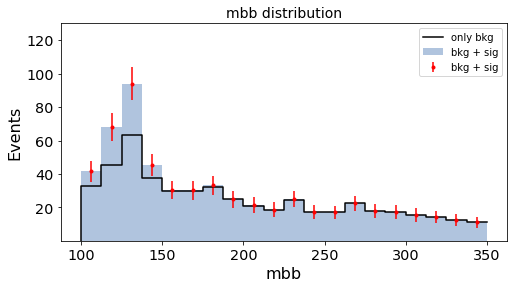

In [50]:
th = 7.15
bins = 20

f,a = plt.subplots(1,1, figsize=(8, 4))

histo_range = (range_mbb[0], range_mbb[1])

counts_b, edges_b = np.histogram((mbb_from_root_b[mbb_from_root_b['reco_loss']>th]['mbb']).astype(float)
                                                    ,range = histo_range,
                                 bins = bins, weights=mbb_from_root_b[mbb_from_root_b['reco_loss']>th]['weight'])

a.step(x=edges_b, y=np.insert(counts_b,0,0),
            color = 'black', label = 'only bkg')

counts_bs, edges_bs = np.histogram((mbb_from_root_bs[mbb_from_root_bs['reco_loss']>th]['mbb']).astype(float)
                                                    ,range = histo_range,
                                 bins = bins,
                                weights=mbb_from_root_bs[mbb_from_root_bs['reco_loss']>th]['weight'])

a.hist((mbb_from_root_bs[mbb_from_root_bs['reco_loss']>th]['mbb']).astype(float), range = histo_range,
                    bins = bins, weights=mbb_from_root_bs[mbb_from_root_bs['reco_loss']>th]['weight'],
            color = 'lightsteelblue', label='bkg + sig')
bincenters = 0.5*(edges_bs[1:]+edges_bs[:-1])
a.set_ylim(bottom = 10**-1, top = 130)
a.errorbar(bincenters, counts_bs, yerr=np.sqrt(counts_bs), fmt='.r', label='bkg + sig')
#     a[0].set_yscale('log')
a.legend(fontsize = 10)
# a.yticks(20,25)
a.set_ylabel('Events', fontsize=16)
a.set_xlabel('mbb', fontsize=16)
a.tick_params(labelsize='x-large')
a.set_title('mbb distribution', fontsize = 14)

plt.savefig('plot_results/root_bump_plot/{}/{}_{}.pdf'.format(type_mod,sig,th))

In [51]:
counts_bs[:4]

array([41.52459733, 68.19992958, 94.00884773, 45.48545015])

In [52]:
counts_b[:4]

array([32.67405575, 45.42615339, 63.05482249, 37.84707086])

In [53]:
np.sum(counts_b[:4])

179.0021024939476

In [54]:
counts_bs[:4] - counts_b[:4]

array([ 8.85054158, 22.77377619, 30.95402524,  7.63837928])

In [55]:
#model dependent
np.sum(counts_bs[:4] - counts_b[:4])

70.21672228926798

In [66]:
#model independent
np.sum(counts_bs[:4] - counts_b[:4])

83.37573757511325